In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt

from pyinverse.phantom import Phantom
from pyinverse.axis import RegularAxis
from pyinverse.grid import RegularGrid

In [3]:
Nx = 64
Ny = 73
Na = 100
Np = 81

In [4]:
R_fname = f'../proj_matrix/R_{Nx}_{Ny}_{Na}_{Np}.npz'
R = scipy.sparse.load_npz(R_fname)

In [5]:
axis_x = RegularAxis.linspace(-1, 1, Nx)
axis_y = RegularAxis.linspace(-1, 1, Ny)
axis_t = RegularAxis.linspace(-1, 1, Np)
axis_theta = RegularAxis.linspace(0, 180, Na, endpoint=False)

In [6]:
print(axis_x)
print(axis_y)
print(axis_t)
print(axis_theta)

RegularAxis: -1.0 -- 1.0, N=64, T=0.031746031746031744
RegularAxis: -1.0 -- 1.0, N=73, T=0.027777777777777776
RegularAxis: -1.0 -- 1.0, N=81, T=0.025
RegularAxis: 0.0 -- 178.20000000000002, N=100, T=1.8


In [7]:
grid = RegularGrid(axis_x, axis_y)
grid_y = RegularGrid(axis_theta, axis_t)

In [8]:
print(grid)

RegularGrid:
axis x: RegularAxis: -1.0 -- 1.0, N=64, T=0.031746031746031744
axis y: RegularAxis: -1.0 -- 1.0, N=73, T=0.027777777777777776


In [9]:
print(grid_y)

RegularGrid:
axis x: RegularAxis: 0.0 -- 178.20000000000002, N=100, T=1.8
axis y: RegularAxis: -1.0 -- 1.0, N=81, T=0.025


In [10]:
p = Phantom()

In [11]:
y = p.sinogram(grid_y, rect=True)
y.shape

(81, 100)

<IPython.core.display.Javascript object>


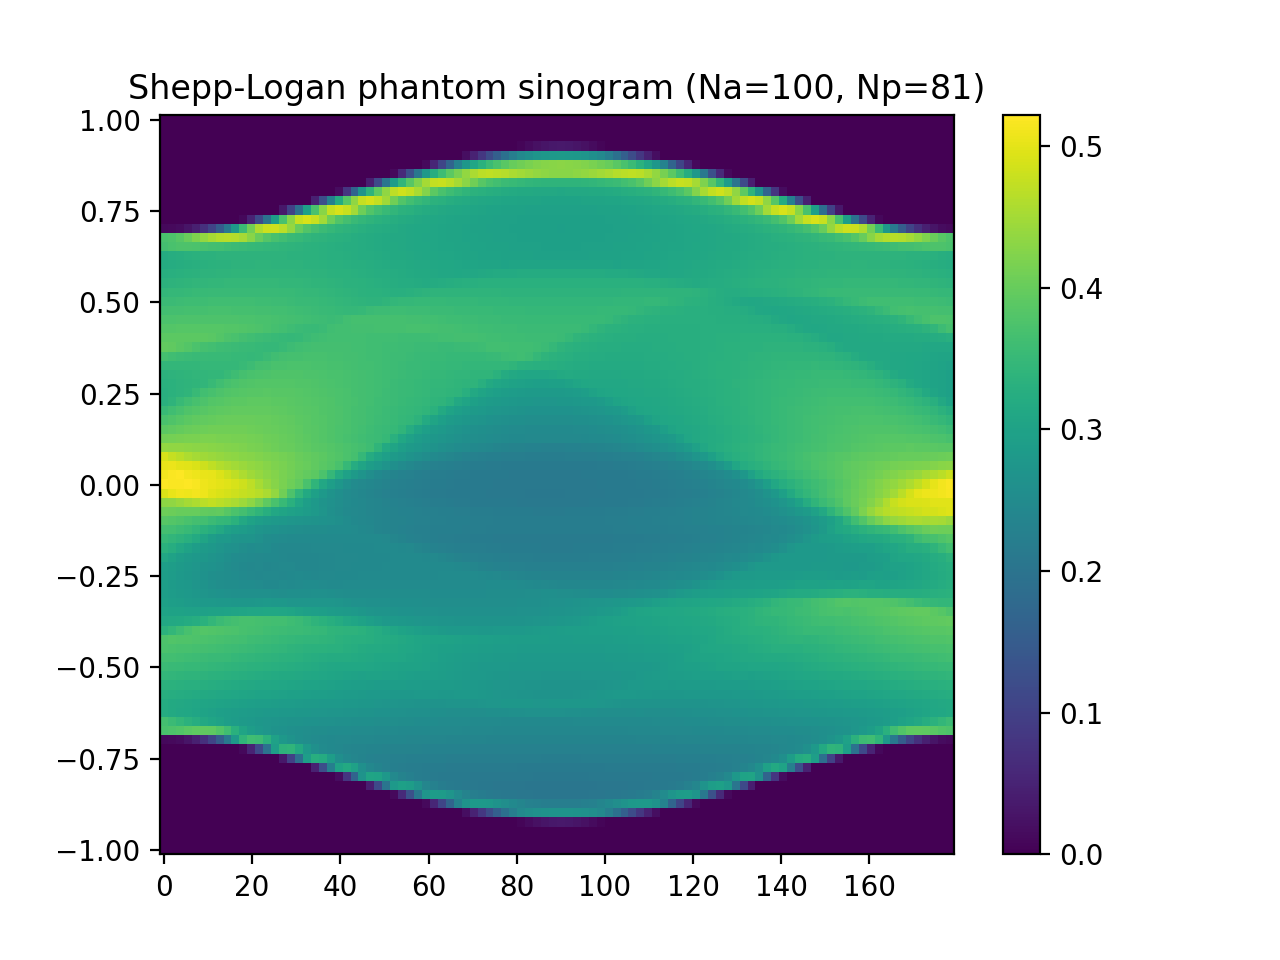

In [12]:
fig, ax = plt.subplots()
im = grid_y.plot(ax, y, aspect='auto')
fig.colorbar(im)
ax.set_title(f'Shepp-Logan phantom sinogram (Na={Na}, Np={Np})');

In [13]:
grid_y_ft = grid_y.spectrum_grid(axis=0)

In [14]:
y_ft = p.proj_ft(grid_y_ft.Hz(axis=0), rect=True)

In [15]:
grid_y_fft, y_fft = grid_y.spectrum(y, axis=0)

In [16]:
grid_y_ft

<FreqRegularGrid <axis_x: <RegularAxis x0=0 T=1.8 N=100>> <axis_y: <FFTRegularAxis x0=-124.11230236404121 T=3.1028075591010302 N=81>>>

In [17]:
grid_y_fft  # should be equal to grid_y_ft

<FreqRegularGrid <axis_x: <RegularAxis x0=0 T=1.8 N=100>> <axis_y: <FFTRegularAxis x0=-124.11230236404121 T=3.1028075591010302 N=81>>>

<IPython.core.display.Javascript object>


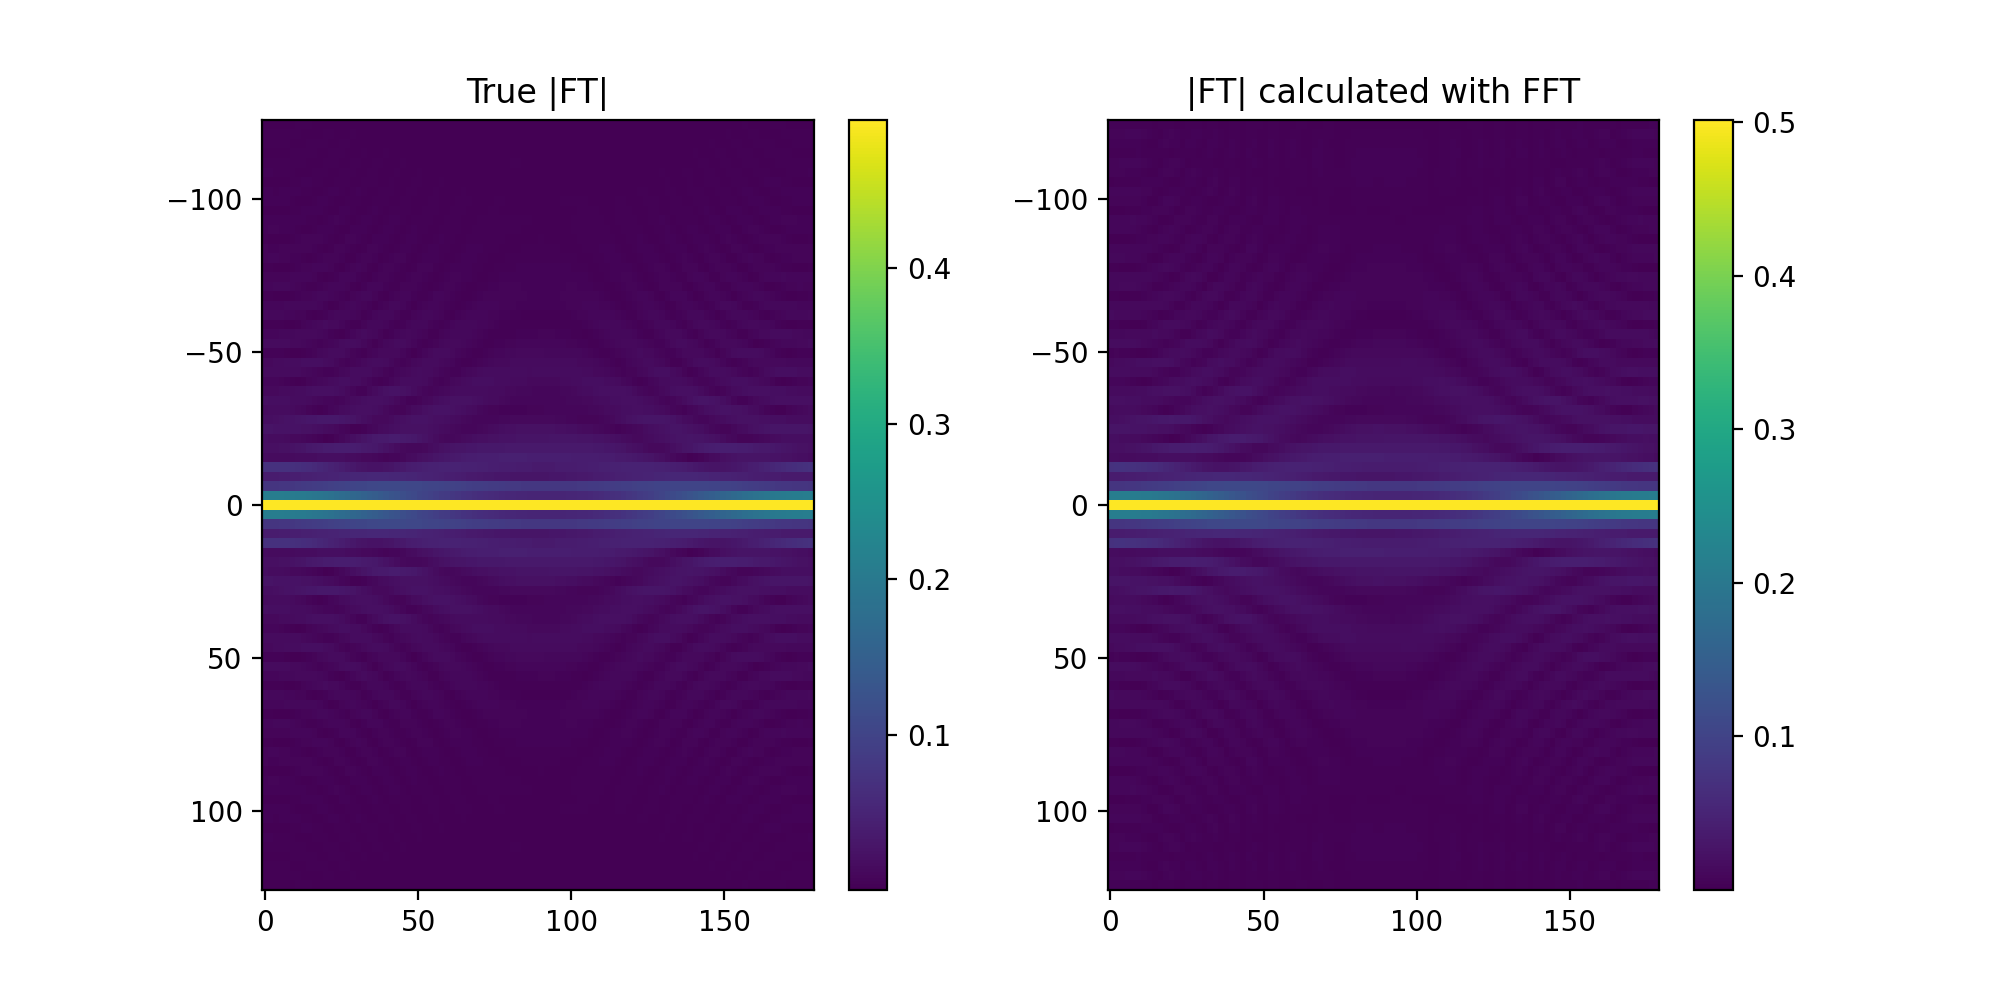

In [18]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
im0 = grid_y_ft.plot(ax[0], np.abs(y_ft))
fig.colorbar(im0, ax=ax[0])
ax[0].set_title('True |FT|')
im1 = grid_y_fft.plot(ax[1], np.abs(y_fft))
fig.colorbar(im1, ax=ax[1])
ax[1].set_title('|FT| calculated with FFT');

In [19]:
grid_z_no_filter, z_no_filter = grid_y_ft.ispectrum(y_ft, axis=0)

In [20]:
grid_y

<RegularGrid <axis_x: <RegularAxis x0=0 T=1.8 N=100>> <axis_y: <RegularAxis x0=-1 T=0.025 N=81>>>

In [21]:
grid_z_no_filter  # should be the same as grid_y

<RegularGrid <axis_x: <RegularAxis x0=0 T=1.8 N=100>> <axis_y: <RegularAxis x0=-1 T=0.025 N=81>>>

In [22]:
assert np.allclose(np.imag(z_no_filter), 0)
z_no_filter = np.real(z_no_filter)

<IPython.core.display.Javascript object>


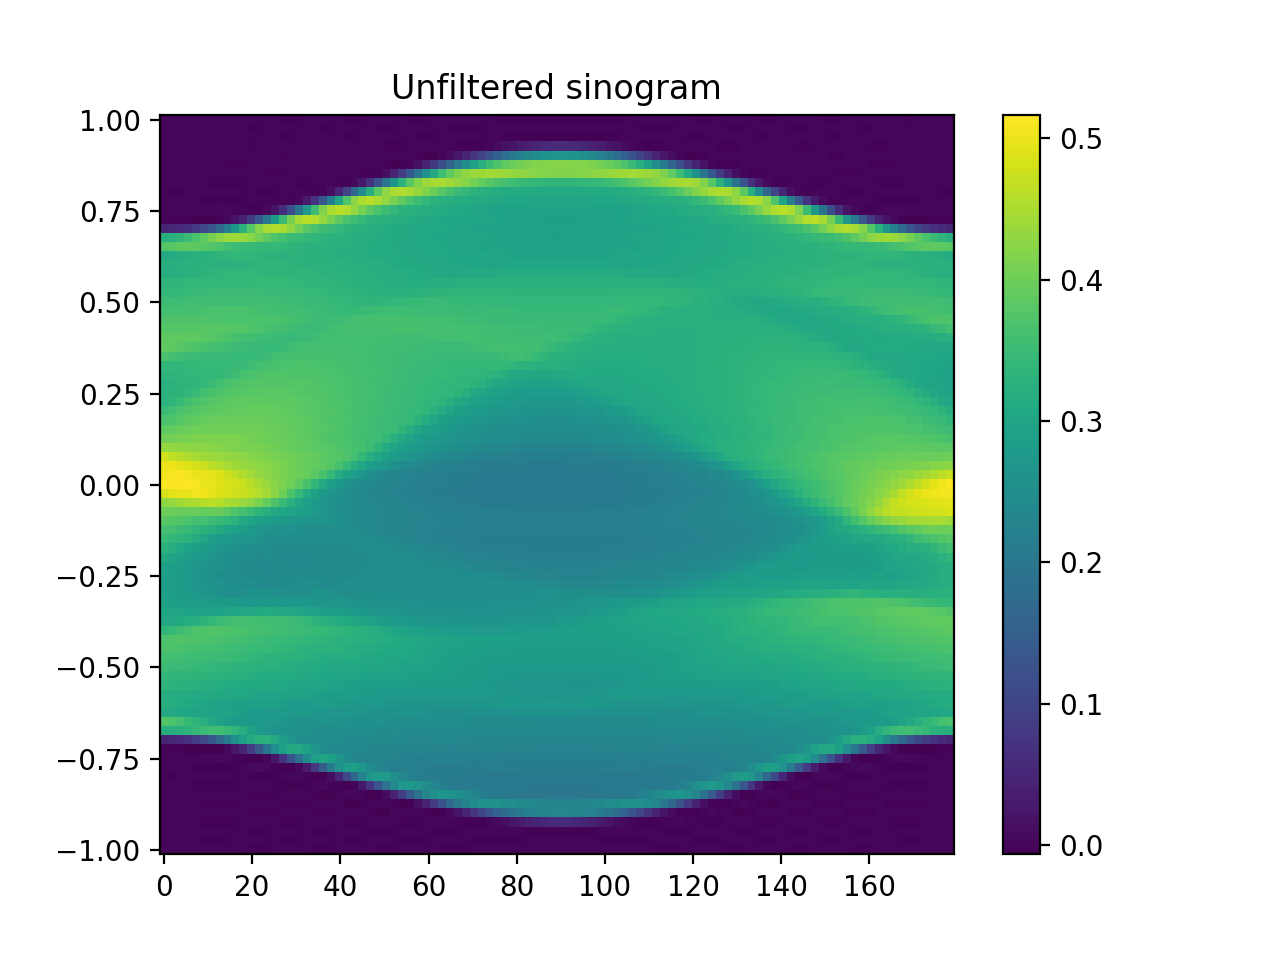

In [23]:
fig, ax = plt.subplots()
im = grid_z_no_filter.plot(ax, z_no_filter, aspect='auto')
fig.colorbar(im)
ax.set_title(f'Unfiltered sinogram');

In [24]:
x_bp = R.T @ z_no_filter.flat
x_bp.shape = Ny, Nx

In [25]:
x_bp.shape

(73, 64)

In [26]:
grid

<RegularGrid <axis_x: <RegularAxis x0=-1 T=0.031746031746031744 N=64>> <axis_y: <RegularAxis x0=-1 T=0.027777777777777776 N=73>>>

<IPython.core.display.Javascript object>


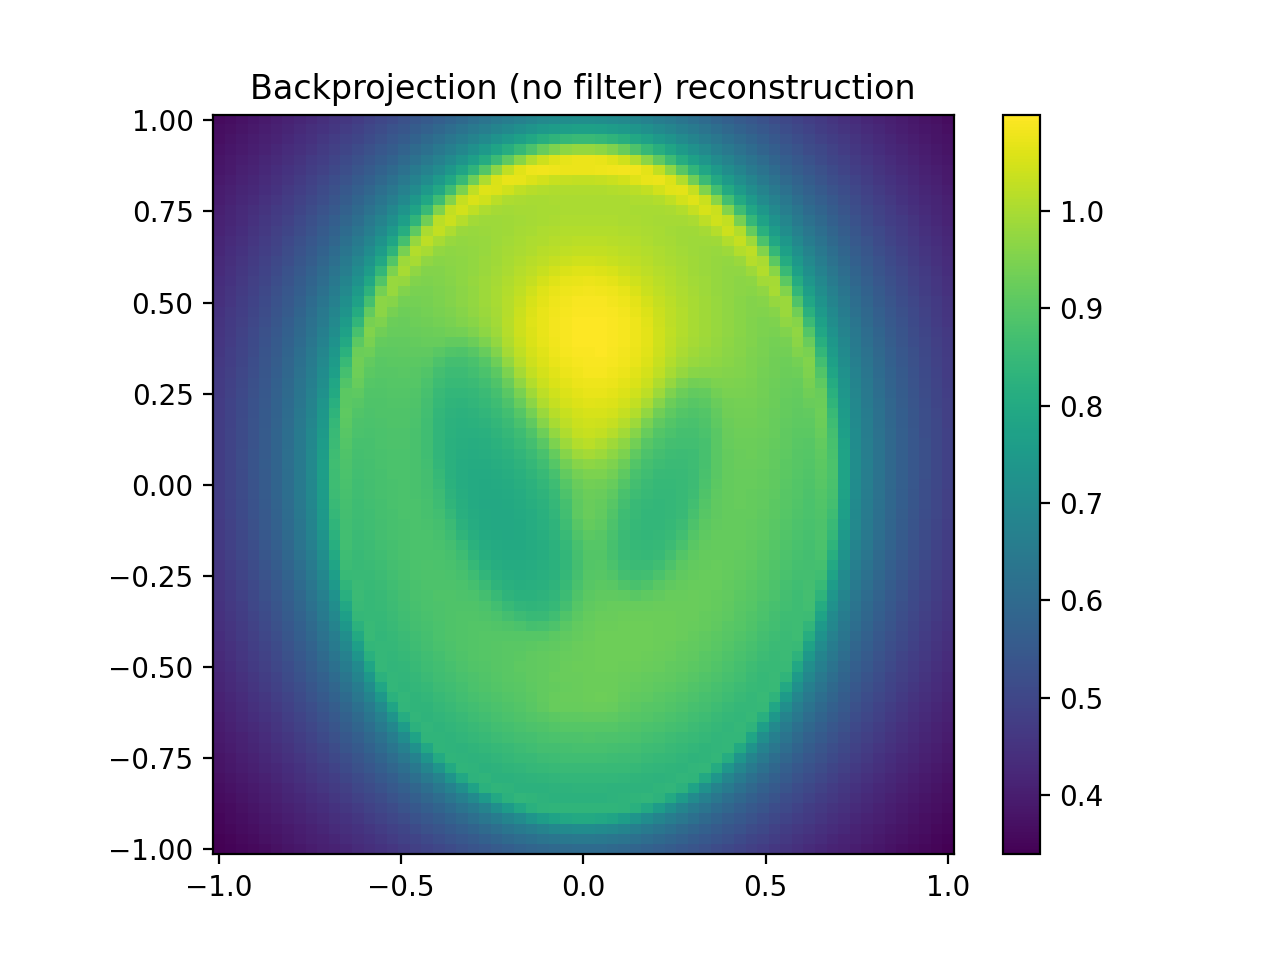

In [27]:
fig, ax = plt.subplots()
im = grid.plot(ax, x_bp)
fig.colorbar(im)
ax.set_title('Backprojection (no filter) reconstruction');

In [28]:
W = np.abs(grid_y_ft.axis_y.centers / (2 * np.pi)) # W(f) = |f|

In [29]:
grid_y.axis_y

<RegularAxis x0=-1 T=0.025 N=81>

<IPython.core.display.Javascript object>


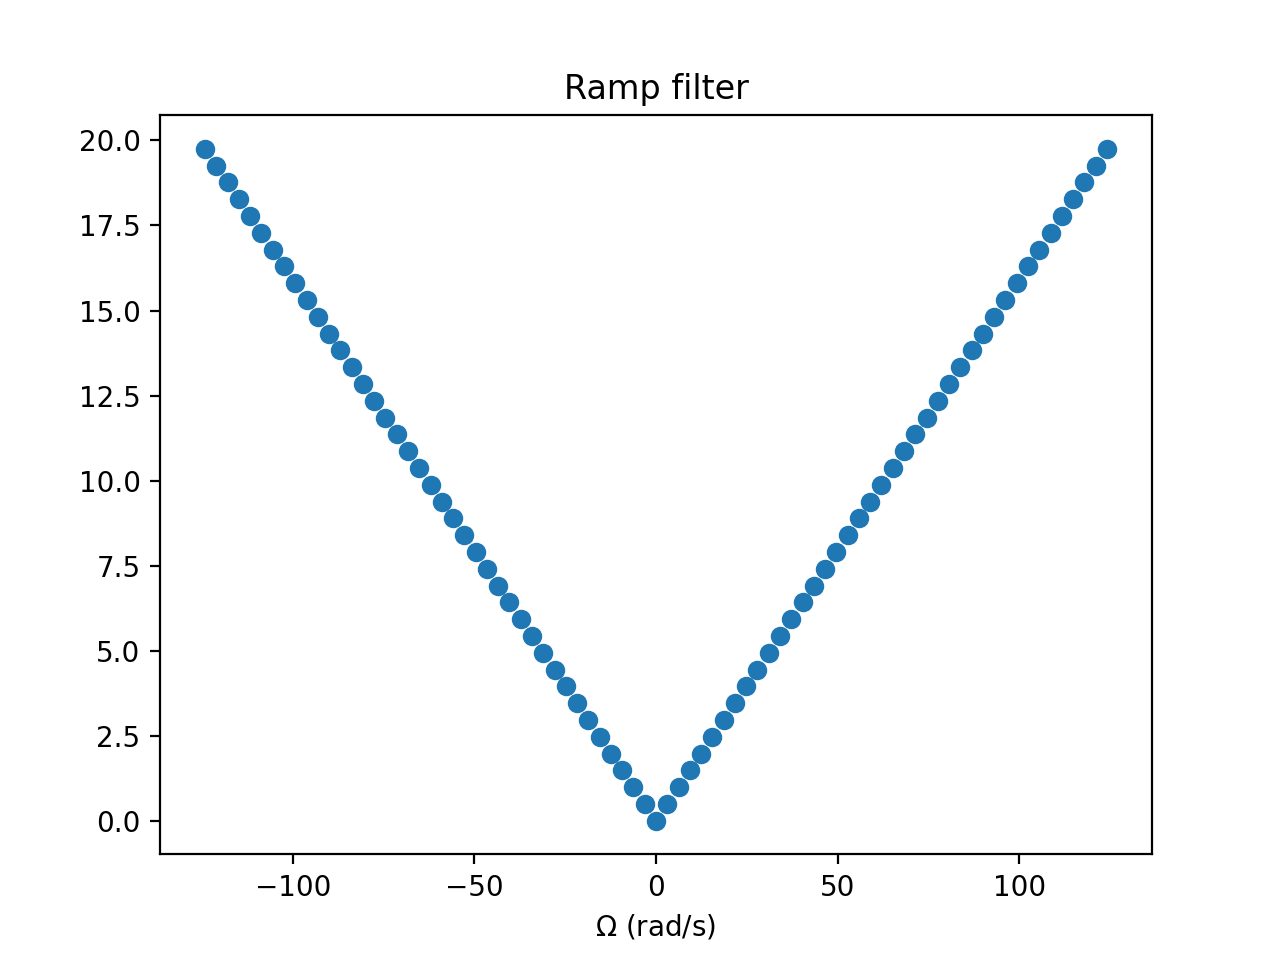

In [30]:
fig, ax = plt.subplots()
plt.scatter(grid_y_ft.axis_y.centers, W)
ax.set_xlabel(r'$\Omega$ (rad/s)')
ax.set_title('Ramp filter');

In [31]:
grid_z_filter, z_filter = grid_y_ft.ispectrum(np.atleast_2d(W).T * y_ft, axis=0)

In [32]:
grid_y

<RegularGrid <axis_x: <RegularAxis x0=0 T=1.8 N=100>> <axis_y: <RegularAxis x0=-1 T=0.025 N=81>>>

In [33]:
grid_z_filter  # should be equal to grid_y

<RegularGrid <axis_x: <RegularAxis x0=0 T=1.8 N=100>> <axis_y: <RegularAxis x0=-1 T=0.025 N=81>>>

In [34]:
assert np.allclose(np.imag(z_filter), 0)
z_filter = np.real(z_filter)

<IPython.core.display.Javascript object>


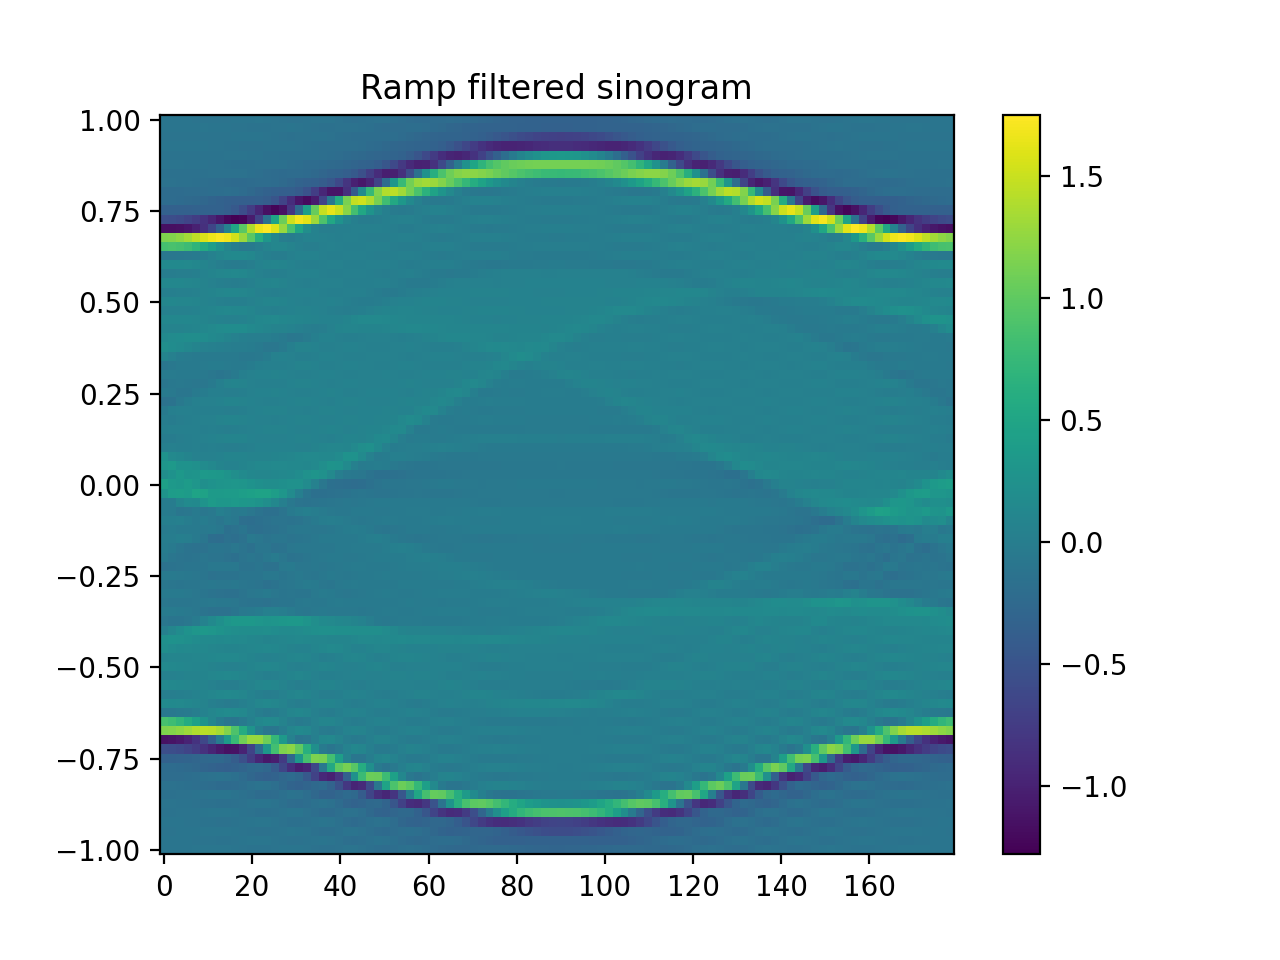

In [35]:
fig, ax = plt.subplots()
im = grid_z_filter.plot(ax, z_filter, aspect='auto')
fig.colorbar(im)
ax.set_title(f'Ramp filtered sinogram');

In [36]:
x_fbp = R.T @ z_filter.flat
x_fbp.shape = Ny, Nx

<IPython.core.display.Javascript object>


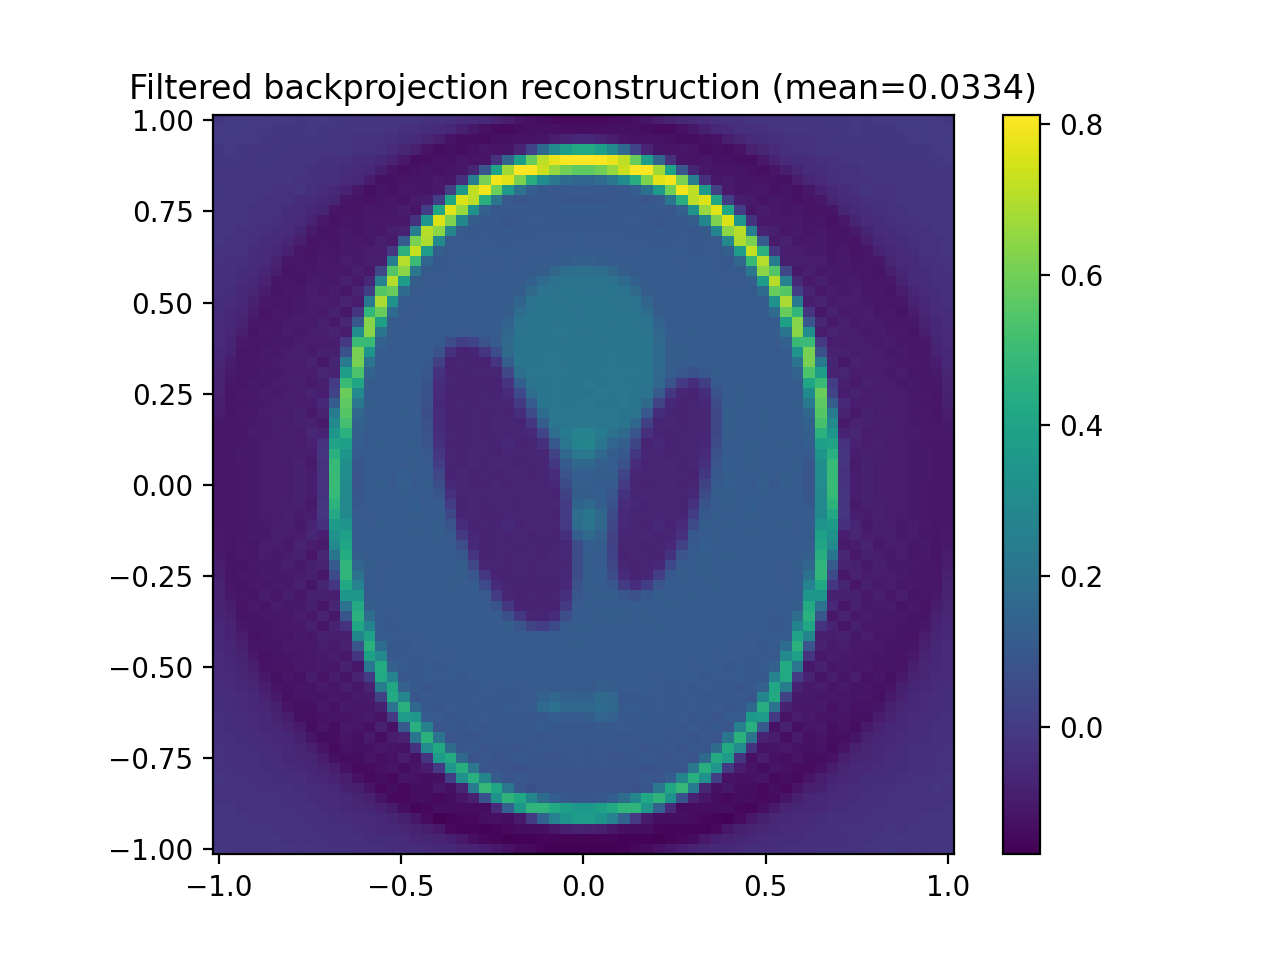

In [37]:
fig, ax = plt.subplots()
im = grid.plot(ax, x_fbp)
fig.colorbar(im)
ax.set_title(f'Filtered backprojection reconstruction (mean={np.mean(x_fbp):.4f})');

In [38]:
np.mean(x_fbp)

0.03337067180221824

In [39]:
x_true = p.raster(grid)

In [40]:
np.mean(x_true)

0.12019349315068482

<IPython.core.display.Javascript object>


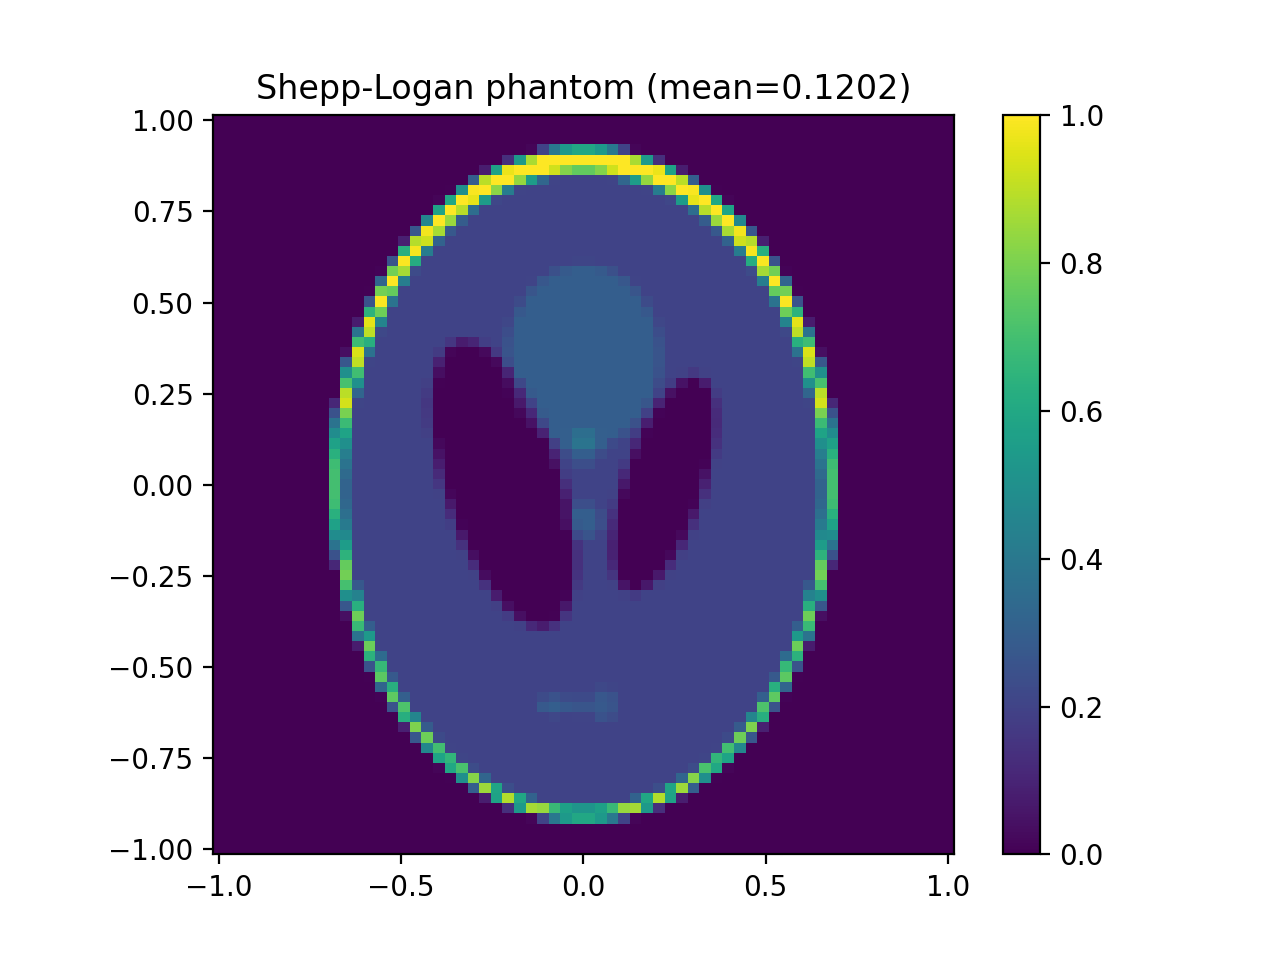

In [41]:
fig, ax = plt.subplots()
im = grid.plot(ax, x_true)
fig.colorbar(im)
ax.set_title(f'Shepp-Logan phantom (mean={np.mean(x_true):.4f})');